In [1]:
import numpy as np
import torch
import torch.nn.functional as F
from af22c.proteome import MultipleSeqAlign
import matplotlib.pyplot as plt
from timeit import timeit
from tqdm import tqdm
from itertools import combinations

In [3]:
prot_path = "../data/A0A0A0MRZ7.a3m"
prot = MultipleSeqAlign.from_a3m(prot_path)

100%|█████████████████████████████████████████████████████████████████| 9846/9846 [00:00<00:00, 164369.91it/s]


In [18]:
vocab = sorted(list(set("".join([str(prot.query_seq)] + [str(match.aligned_seq) for match in prot.matches]))))
"".join(vocab),len(vocab)

('-ACDEFGHIKLMNPQRSTVWXY', 22)

In [19]:
stoi = {c:i for i, c in enumerate(vocab)}
itos = {i:c for c, i in stoi.items()}

In [41]:
query_len = len(prot.query_seq)
num_matches = len(prot.matches)
num_seqs = num_matches + 1 # include query
query_len,num_matches,num_seqs

(120, 9844, 9845)

In [42]:
encmsa = torch.zeros((num_seqs, query_len))
for seqidx, seq in enumerate([prot.query_seq] + [match.aligned_seq for match in prot.matches]):
    for colidx, colval in enumerate(seq):
        encmsa[seqidx, colidx] = stoi[colval]
encmsa.shape

torch.Size([9845, 120])

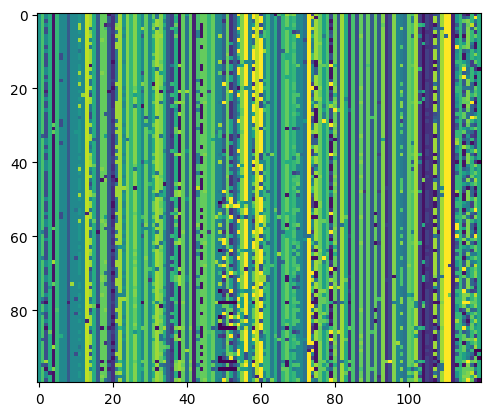

In [43]:
plt.imshow(encmsa[:100])

In [45]:
smallmsa = encmsa[:10,8:18] # (num_seqs, query_len)
# adjust variables for toy example
num_seqs, query_len = smallmsa.shape
num_matches = num_seqs - 1

Text(0.5, 0, 'AA index')

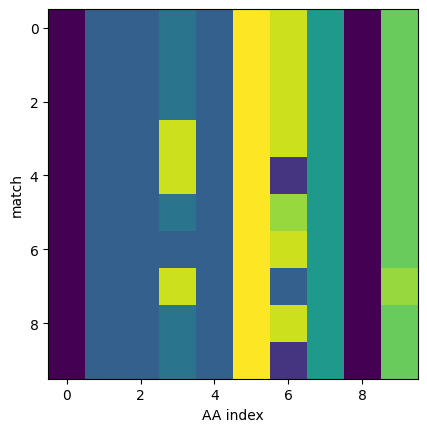

In [46]:
plt.imshow(smallmsa)
plt.ylabel("match")
plt.xlabel("AA index")

In [47]:
# pairwise hamming distances
pwdists = torch.sum(smallmsa[None,:,:] != smallmsa[:,None,:], axis=-1)
# pairwise sequence identities = 1 - normalized hamming distances (each value divided by sequence length)
pwseq = 1 - pwdists / query_len

Text(0, 0.5, 'query seq idx')

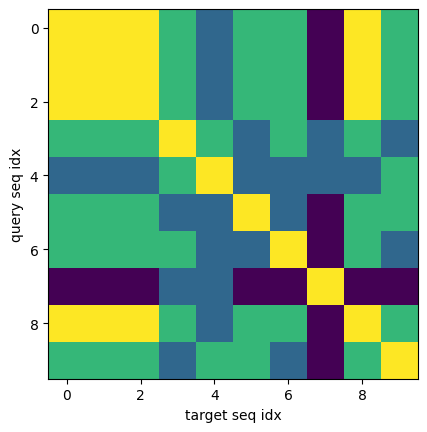

In [48]:
plt.imshow(pwseq)
plt.xlabel("target seq idx")
plt.ylabel("query seq idx")

In [13]:
pwseq[0,0],pwseq[0,3],pwseq[0,4],pwseq[0,7]

(tensor(1.), tensor(0.9000), tensor(0.8000), tensor(0.7000))

with our MSA sizes, it is probably not feasible to run sequence identity checks on the entire MSA. therefore, we need to divide the MSA into smaller batches.

In [15]:
batch_size = 4 # number of sequenes in batch
# calculate all pairs for which pairwise sequence identities need to be calculated
#pairs = torch.cartesian_prod(*(torch.arange(num_seqs),)*2)
pairs = []
for i in range(num_seqs):
    for j in range(i+1, num_seqs):
        pairs.append((i,j))
pairs = torch.tensor(pairs)
pairs.shape

torch.Size([45, 2])

In [16]:
# each batch should yield a matrix with batch_size elements
num_batches = (len(pairs) + batch_size - 1) // batch_size
num_batches

12

In [17]:
# one batch contains batch_size many pairs, which yields batch_size many similarity scores because the 
# similarity matrix is symmetric.
bpwseq = torch.eye(num_seqs) # matrix containing similarity scores for two sequences
for batch_idx in range(num_batches):
    # calculate similarity scores for a batch
    pairs_idx = torch.arange(batch_idx*batch_size, min((batch_idx + 1)*batch_size, len(pairs)))
    batch_pairs = pairs[pairs_idx]

    # calculate sequences in batch
    batch_seqs = torch.zeros((batch_size, 2, query_len))
    for pair_idx, (i, j) in enumerate(batch_pairs):
        # TODO: get rid of float conversion?
        batch_seqs[pair_idx, 0] = smallmsa[i].float()
        batch_seqs[pair_idx, 1] = smallmsa[j].float()

    batch_pwdists = torch.sum(batch_seqs[:,0,:] != batch_seqs[:,1,:], axis=-1)
    batch_pwseq = 1 - batch_pwdists / query_len
    for pair_idx, (i, j) in enumerate(batch_pairs):
        bpwseq[i,j] = bpwseq[j,i] = batch_pwseq[pair_idx]

Text(0.5, 1.0, 'complete MSA pairwise seq identity')

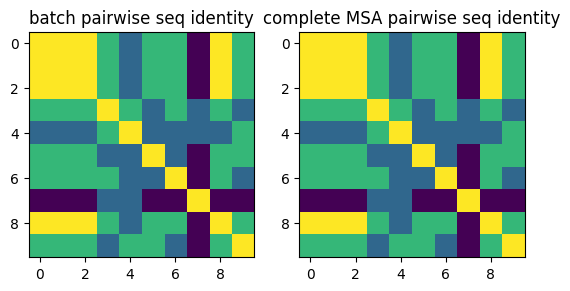

In [18]:
fig,(ax1,ax2) = plt.subplots(ncols=2)
ax1.imshow(bpwseq)
ax1.set_title("batch pairwise seq identity")
ax2.imshow(pwseq)
ax2.set_title("complete MSA pairwise seq identity")

In [19]:
assert torch.allclose(bpwseq, pwseq)

In [28]:
# baseline: 30.474739761004457s
timeit(lambda: prot.compute_neff(), number=1)

16it [00:04,  3.21it/s]
100%|████████████████████████████████████████| 120/120 [00:00<00:00, 197.11it/s]


30.696222850005142

In [3]:
from neff_gpu import neff
neff

<function neff_gpu.neff(msa, pwseqfn=<function pwseq at 0x7f66488f1510>, seqid_thres=0.8, **kwargs)>

In [4]:
#timeit(lambda: compute_neff(prot), number=1)
# baseline: 20.309782647993416s
timeit(lambda: neff(prot, batch_size=10000), number=1)

converting msa: 9845it [00:04, 2254.48it/s]
running batches: 100%|████████████████████| 4846/4846 [00:02<00:00, 1844.94it/s]


20.120374978985637

## Combined functionality

The cells below combine the derived Neff score calculations from the cells above to be able to evaluate small changes to the function.

In [51]:
def fn1(encmsa):
    batch_size = 4 # number of sequenes in batch
    # calculate all pairs for which pairwise sequence identities need to be calculated
    #pairs = torch.cartesian_prod(*(torch.arange(num_seqs),)*2)
    pairs = []
    for i in range(num_seqs):
        for j in range(i+1, num_seqs):
            pairs.append((i,j))
    pairs = torch.tensor(pairs)
    
    # each batch should yield a matrix with batch_size elements
    num_batches = (len(pairs) + batch_size - 1) // batch_size
    
    bpwseq = torch.eye(num_seqs) # matrix containing similarity scores for two sequences
    for batch_idx in range(num_batches):
        # calculate similarity scores for a batch
        pairs_idx = torch.arange(batch_idx*batch_size, min((batch_idx + 1)*batch_size, len(pairs)))
        batch_pairs = pairs[pairs_idx]

        # calculate sequences in batch
        batch_seqs = torch.zeros((batch_size, 2, query_len))
        for pair_idx, (i, j) in enumerate(batch_pairs):
            # TODO: get rid of float conversion?
            batch_seqs[pair_idx, 0] = encmsa[i].float()
            batch_seqs[pair_idx, 1] = encmsa[j].float()

        batch_pwdists = torch.sum(batch_seqs[:,0,:] != batch_seqs[:,1,:], axis=-1)
        batch_pwseq = 1 - batch_pwdists / query_len
        for pair_idx, (i, j) in enumerate(batch_pairs):
            bpwseq[i,j] = bpwseq[j,i] = batch_pwseq[pair_idx]
    return bpwseq
assert torch.allclose(fn1(smallmsa), pwseq)

In [52]:
def fn2(encmsa):
    batch_size = 4 # number of sequenes in batch
    # calculate all pairs for which pairwise sequence identities need to be calculated
    #pairs = torch.cartesian_prod(*(torch.arange(num_seqs),)*2)
    pairs = []
    for i in range(num_seqs):
        for j in range(i+1, num_seqs):
            pairs.append((i,j))
    pairs = torch.tensor(pairs)
    
    # each batch should yield a matrix with batch_size elements
    num_batches = (len(pairs) + batch_size - 1) // batch_size
    
    bpwseq = torch.eye(num_seqs) # matrix containing similarity scores for two sequences
    for batch_idx in range(num_batches):
        # calculate similarity scores for a batch
        pairs_idx = torch.arange(batch_idx*batch_size, min((batch_idx + 1)*batch_size, len(pairs)))
        batch_pairs = pairs[pairs_idx]
        batch_pairs_flat = batch_pairs.view(-1)
        
        # calculate sequences in batch
        batch_seqs = encmsa[batch_pairs_flat]
        batch_seqs = batch_seqs.view((-1, 2, query_len))

        # calculate pairwise distances 
        batch_pwdists = torch.sum(batch_seqs[:,0,:] != batch_seqs[:,1,:], axis=-1)
        batch_pwseq = 1 - batch_pwdists / query_len
        
        # put at right location in result matrix
        bpwseq[batch_pairs[:,0],batch_pairs[:,1]] = batch_pwseq
        bpwseq[batch_pairs[:,1],batch_pairs[:,0]] = batch_pwseq
    return bpwseq
assert torch.allclose(fn2(smallmsa), pwseq)

In [53]:
print(f"fn1: {timeit(lambda: fn1(smallmsa), number=100)}s")
print(f"fn2: {timeit(lambda: fn2(smallmsa), number=100)}s")

fn1: 0.17003173200646415s
fn2: 0.0820879689999856s


## Move to GPU

In [67]:
# calculate reference neff scores from protein
neffref = prot.compute_neff()

16it [00:05,  3.19it/s]
100%|████████████████████████████████████████| 120/120 [00:00<00:00, 192.66it/s]


In [115]:
neffref

array([1490.70567076, 1586.53555204, 1826.66174252, 1907.04083608,
       2189.57790637, 2250.46957303, 2508.90290637, 2742.4862397 ,
       2798.42592224, 2998.80026595, 3158.75026595, 3255.91103245,
       3380.02614789, 3433.22522889, 3513.60320282, 3668.56930202,
       3844.87360497, 4013.03508424, 4104.75035694, 4199.31778657,
       4444.65155671, 4395.85763792, 4605.90154253, 4861.0781052 ,
       4915.4781052 , 4981.69263816, 4344.51135773, 5058.80644769,
       4468.88772163, 5100.22174073, 5315.61860428, 5302.20193761,
       5481.15882864, 5534.04216197, 5564.29613023, 5654.34613023,
       5681.7730533 , 5710.5230533 , 5719.18971997, 5735.0230533 ,
       5758.35638664, 5742.83257711, 5753.11591045, 4883.59613728,
       4645.40730944, 4956.2468708 , 4438.84414554, 4310.90713014,
       4241.63619306, 3355.92092586, 3533.49948739, 3965.45344846,
       3989.31671524, 4286.79634277, 4701.02520773, 4812.53278087,
       5075.61135483, 5487.23515067, 5679.95794032, 5907.70018

In [40]:
def fn3(encmsa, **kwargs):
    num_seqs,query_len = encmsa.shape

    batch_size = 16384 # number of sequenes in batch
    # calculate all pairs for which pairwise sequence identities need to be calculated
    #pairs = torch.cartesian_prod(*(torch.arange(num_seqs),)*2)
    print("generating pairs")
    pairs = list(combinations(range(num_seqs),2))
    pairs = torch.tensor(pairs)
    print("done")
    
    # each batch should yield a matrix with batch_size elements
    num_batches = (len(pairs) + batch_size - 1) // batch_size
    
    bpwseq = torch.eye(num_seqs) # matrix containing similarity scores for two sequences
    for batch_idx in tqdm(range(num_batches), desc="running batches"):
        # calculate similarity scores for a batch
        pairs_idx = torch.arange(batch_idx*batch_size, min((batch_idx + 1)*batch_size, len(pairs)))
        batch_pairs = pairs[pairs_idx]
        batch_pairs_flat = batch_pairs.view(-1)
        
        # calculate sequences in batch
        batch_seqs = encmsa[batch_pairs_flat]
        batch_seqs = batch_seqs.view((-1, 2, query_len))

        # calculate pairwise distances 
        batch_pwdists = torch.sum(batch_seqs[:,0,:] != batch_seqs[:,1,:], axis=-1)
        batch_pwseq = 1 - batch_pwdists / query_len
        
        # put at right location in result matrix
        bpwseq[batch_pairs[:,0],batch_pairs[:,1]] = batch_pwseq
        bpwseq[batch_pairs[:,1],batch_pairs[:,0]] = batch_pwseq
    return bpwseq

In [66]:
pwseq = fn4(encmsa)

AttributeError: 'NoneType' object has no attribute 'shape'

In [42]:
def gapcount(encmsa, weights=None, gaptok=None, stoi=None, nongap=False, **kwargs):
    """
    calculate number of gaps in each msa column. returns a vector of length query_len.
    weights can be specified to weight each sequence in the msa column.
    if nongap=False (default), gaps will be counted; otherwise non-gaps will be counted.
    the gaps are identified by gaptok, which can be the token id for gaps. alternatively, a
    dictionary stoi can be supplied, where the gaptok is looked up.
    """
    if gaptok is None:
        assert stoi is not None
        gaptok = stoi['-']
    gapindicator = encmsa != gaptok if nongap else encmsa == gaptok
    if weights is not None:
        return weights @ gapindicator.float()
    return torch.sum(gapindicator, dim=0)

def neff(encmsa, pwseqfn=fn3, seqid_thres=0.8, **kwargs):
    """
    calculate neff scores for an encoded msa.
    """
    num_seqs, query_len = encmsa.shape
    pwseq = pwseqfn(encmsa, **kwargs)
    # calculate neff weights (dim can be 0 or 1, does not matter because pwseq is symmetric)
    neffweights = 1 / torch.sum(pwseq >= seqid_thres, dim=0)
    return gapcount(encmsa, weights=neffweights, nongap=True, **kwargs)

#neff_fast = neff(encmsa)

In [43]:
torch.allclose(torch.tensor(neffref).float(), neff_fast)

NameError: name 'neffref' is not defined

In [44]:
plt.plot(neffref)
plt.plot(neff_fast)

NameError: name 'neffref' is not defined

## Accellerating file loading

In the new neff score calculation, a lot of time is spent encoding the MSA. Can we combine file loading and encoding?

In [45]:
from string import ascii_lowercase
def loadmsa(path):
    """load an MSA as an encoded tensor"""
    with open(path) as f:
        lines = f.readlines()
        query_len = len([ch for ch in lines[1].strip() if not ch in ascii_lowercase])
        num_seqs = len(lines) // 2
        encmsa = torch.zeros((num_seqs,query_len), dtype=torch.uint8)
        for idx, line in enumerate(lines[1::2]):
            encmsa[idx,:] = torch.tensor(
                # NB: stoi comes from outside!
                [stoi[ch] for ch in line.strip() if not ch in ascii_lowercase],
                dtype=torch.uint8,
            )
        return encmsa

In [46]:
# baseline: 15.939979004993802s
timeit(lambda: neff(loadmsa(prot_path), stoi=stoi), number=1)

generating pairs
done


running batches: 100%|███████████████████████████████████████████████████| 2959/2959 [00:04<00:00, 720.72it/s]


15.939979004993802

## Generating pairs

The second thing taking a long time is the generating a list of pairs that need to be processed. This can be done faster...

In [61]:
n,m=100,100

In [62]:
timeit(lambda: list(combinations(range(n*m),2)), number=10)

20.193270335003035

In [63]:
timeit(lambda: torch.triu_indices(n,m,1), number=10)

0.0005395599873736501